In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy import stats
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
from statsmodels.distributions.mixture_rvs import mixture_rvs
%matplotlib inline

In [31]:
#load in h5 file and indices files
h5_filepath = "/home/mattStubbs/watchmal/NeutronGNN/data/h5_files/iwcd_mpmt_shorttank_neutrongnn_6files.h5"
train_indices_file = "/home/mattStubbs/watchmal/NeutronGNN/data/splits/train_indicies_6.txt"
val_indices_file = "/home/mattStubbs/watchmal/NeutronGNN/data/splits/validation_indicies_6.txt"
test_indices_file = "/home/mattStubbs/watchmal/NeutronGNN/data/splits/test_indicies_6.txt"

To access any part of the h5 dataset, <br> 
1) read the h5 file, 2) create a memory mapping to it <br>

looking into the h5 file... <br> 
x_data = [charge, time, pmt_position_x, pmt_position_y, pmt_position_z, pmt_direction_x, pmt_direction_y, pmt_direction_z] <br>
'labels' == particle id, ... , 
'event_data' == x_data

In [32]:
with h5py.File(h5_filepath, 'r') as file:
    print(list(file.keys()))
    h5_event_data = file['event_data']
    h5_nhits = file['nhits']
    h5_labels = file['labels']
    labels = np.array(h5_labels)
    
    event_mem_data = np.memmap(h5_filepath, mode='r', shape=h5_event_data.shape,
                               offset=h5_event_data.id.get_offset(),
                               dtype=h5_event_data.dtype)
    print("Event memory data shape: " + str(event_mem_data.shape))
    print("1634 events. Up to 300 hits per event. 8 features per hit per event")
    nhits = np.array(h5_nhits)

['angles', 'energies', 'event_data', 'event_ids', 'labels', 'nhits', 'positions', 'root_files']
Event memory data shape: (4884, 300, 8)
1634 events. Up to 300 hits per event. 8 features per hit per event


Verify the number of hits per event

[100 100  94  42  58  34 178  84  63 123  49  81 113  53  45  80 128 113
 164  44  88  67  45  40  73 112  69  53 135  65 169  51 138  78  79  72
 120  45 117 189 132  50 115 127  47  60 102  28 148  93 119 148 138 140
  43 129 116  98  32  79  35 119 151 168  68  92 180  34  54  68 144 131
  95 168  97  91  26  38  50  81 130  81 186 116 114  68  76 131 136  50
  56  50  94  64  64 155  95 131 149 127]


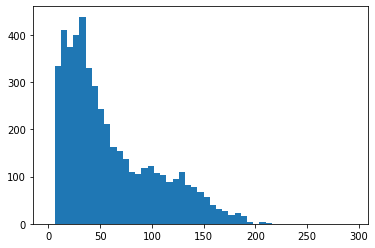

In [33]:
non_zero = [np.count_nonzero(event_mem_data[i,:,0]) for i in range(0, event_mem_data.shape[0])]
non_zero  = np.array(non_zero)

# nhits should be equal to non_zero
plt.hist(nhits, bins=np.arange(0, 300, 6))   # visualize hits histogram

print(nhits[0:100])
assert nhits.all() == non_zero.all()

__Separate nhits array based on whether the event is electron or neutron__

get the index of the electron or neutron events. The way the files have been merged, they have not been shuffled yet - so there will be all events of one type, then all events of the next. <br>
label = 0 -> neutron <br>
label = 1 -> electron

In [34]:
neutron_hits = []
electron_hits = []

print(labels.shape)
# print(nhits[0:50])
# print(labels[0:50])

for i in range(0, event_mem_data.shape[0]):
#     print("event id: ", str(i))
#     print("event label: ", str(labels[i]))
#     print("#hits in event: ", str(nhits[i]))
    if labels[i] == 0:
        neutron_hits.append(nhits[i])
    elif labels[i] == 1:
        electron_hits.append(nhits[i])

(4884,)


Get statistics on the neutron and electron event hit numbers. Visualize difference between hit distributions of neutron and electron events.

Length of neutron hits: (2498,)
Length of electron hits: (2386,)
DescribeResult(nobs=2498, minmax=(6, 93), mean=28.52802241793435, variance=246.9493545978152, skewness=0.8173168976597516, kurtosis=0.2533001300989439)
DescribeResult(nobs=2386, minmax=(26, 212), mean=91.77116512992455, variance=1677.3916378033286, skewness=0.33064958830571534, kurtosis=-0.7475961359297849)


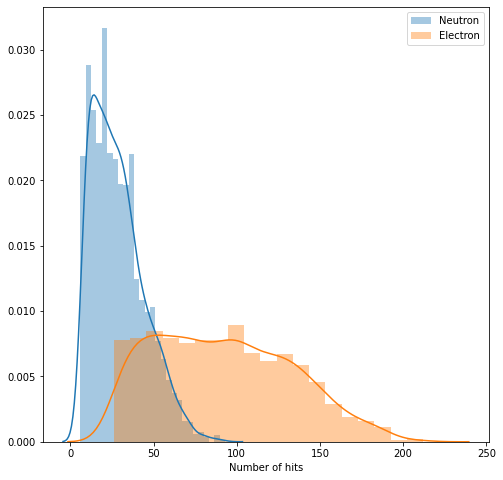

In [35]:
neutron_hits = np.array(neutron_hits)
electron_hits = np.array(electron_hits)

print('Length of neutron hits: {}'.format(neutron_hits.shape))
print('Length of electron hits: {}'.format(electron_hits.shape))

print(stats.describe(neutron_hits))
print(stats.describe(electron_hits))

fig = plt.figure(figsize = (8,8))
sns.distplot(neutron_hits, rug = False, axlabel ="Number of hits", label = "Neutron")
sns.distplot(electron_hits, rug = False, label = "Electron")
plt.legend()
plt.savefig("hit_separation.png") 

__The kernel density estimate (KDE) estimates the probability density function__

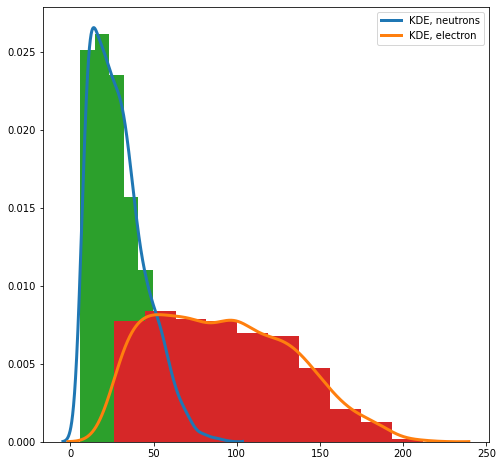

In [36]:
kdeNeutron = sm.nonparametric.KDEUnivariate(neutron_hits)
kdeNeutron.fit() # Estimate the densities

kdeElectron = sm.nonparametric.KDEUnivariate(electron_hits)
kdeElectron.fit() # Estimate the densities

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111) 

ax.plot(kdeNeutron.support, kdeNeutron.density, lw=3, label='KDE, neutrons', zorder= 10)
ax.plot(kdeElectron.support, kdeElectron.density, lw=3, label='KDE, electron', zorder=10)
plt.hist(neutron_hits, density = True)
plt.hist(electron_hits, density = True)

plt.legend()

In [37]:
print(kdeElectron.evaluate(25)) # example of evaluating probability at specific nhits value

[0.00356193]


In [38]:
def likelihood_classifier(nhits, event_data):
    pred_labels = []
    for i in range(0, event_data.shape[0]):
        if kdeElectron.evaluate(nhits[i]) > kdeNeutron.evaluate(nhits[i]):
            pred_labels.append(1)  #electron
        else:
            pred_labels.append(0)  #neutron
    
    pred_labels = np.array(pred_labels)
    return pred_labels

In [39]:
predictions = likelihood_classifier(nhits, event_mem_data)

In [40]:
print(predictions[0:200])
print(labels[0:200])

correct = 0
for x in range(0, event_mem_data.shape[0]):
    if predictions[x] == labels[x]:
        correct += 1

accuracy = correct / event_mem_data.shape[0]
print("Accuracy: " + str(accuracy))

[1 1 1 0 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1
 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Accuracy: 0.8501228501228502


plot likelihood ratio against number of hits

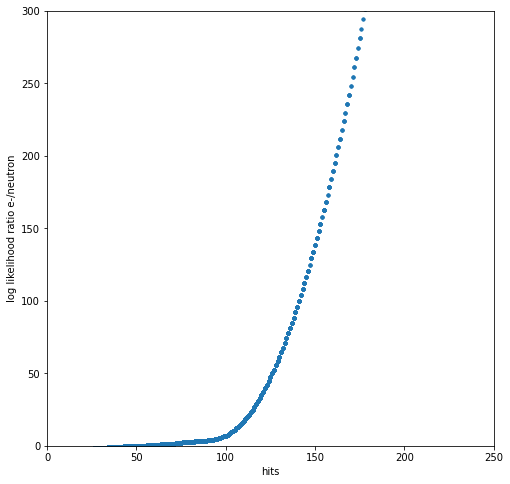

In [41]:
t = []
for i in range(0, event_mem_data.shape[0]):
    if kdeNeutron.evaluate(nhits[i]) != 0:
        t.append(np.log(kdeElectron.evaluate(nhits[i]) / kdeNeutron.evaluate(nhits[i])))  #electron

fig = plt.figure(figsize = (8,8))
axes = fig.gca()
axes.set_xlim([0, 250])
axes.set_ylim([0, 300])
plt.xlabel('hits')
plt.ylabel('log likelihood ratio e-/neutron')
plt.plot(nhits, t, '.')
#plt.savefig("hit_likelihood.png") 

# Charge

x_data = [charge, time, pmt_position_x, pmt_position_y, pmt_position_z,
		pmt_direction_x, pmt_direction_y, pmt_direction_z] <br>

'event_data' == x_data

In [42]:
with h5py.File(h5_filepath, 'r') as file:
    print(list(file.keys()))
    h5_labels = file['labels']
    labels = np.array(h5_labels)
    h5_event_data = file['event_data']
    event_mem_data = np.memmap(h5_filepath, mode='r', shape=h5_event_data.shape,
                               offset=h5_event_data.id.get_offset(),
                               dtype=h5_event_data.dtype)
    print("Event memory data shape: " + str(event_mem_data.shape))
    
    h5_charges = event_mem_data[:, :, 0]
    print(h5_charges.shape)
    #nhits = np.array(h5_nhits)

['angles', 'energies', 'event_data', 'event_ids', 'labels', 'nhits', 'positions', 'root_files']
Event memory data shape: (4884, 300, 8)
(4884, 300)


In [43]:
neutron_charges = []
electron_charges = []

for i in range(0, event_mem_data.shape[0]):
    if labels[i] == 0:
        neutron_charges.append(h5_charges[i, :])
    elif labels[i] == 1:
        electron_charges.append(h5_charges[i, :])   

In [44]:
#### --------------------- by total charge ---------------------- #####
neutron_charge_sums = np.array(neutron_charges)
electron_charge_sums = np.array(electron_charges)

neutron_charge_sums = neutron_charge_sums.sum(axis = 1)
electron_charge_sums = electron_charge_sums.sum(axis = 1)

print(""), print(neutron_charge_sums.shape)
print(electron_charge_sums.shape), print("")

print("neutron charge sums ... \n {} {}".format(str(neutron_charge_sums[:10]), "...")), print(" ") 
print("electron charge sums ... \n {} {}".format(str(electron_charge_sums[:10]), "..."))


(2498,)
(2386,)

neutron charge sums ... 
 [13.500842 44.59752  22.378988 46.513557 32.925224 19.250637 26.61465
 36.011833 24.248478 45.887913] ...
 
electron charge sums ... 
 [118.86579  107.3151   113.466995  44.158176  66.61594   37.502594
 203.2453   115.34874   69.219055 136.2128  ] ...


neutron charge stats ... 
DescribeResult(nobs=2498, minmax=(4.123454, 193.33264), mean=33.52015, variance=376.0269, skewness=1.0973753929138184, kurtosis=2.30954576601658)

electron charge stats ... 
DescribeResult(nobs=2386, minmax=(26.714218, 372.3196), mean=116.142525, variance=2795.372, skewness=0.3704686760902405, kurtosis=-0.20815019035034643)


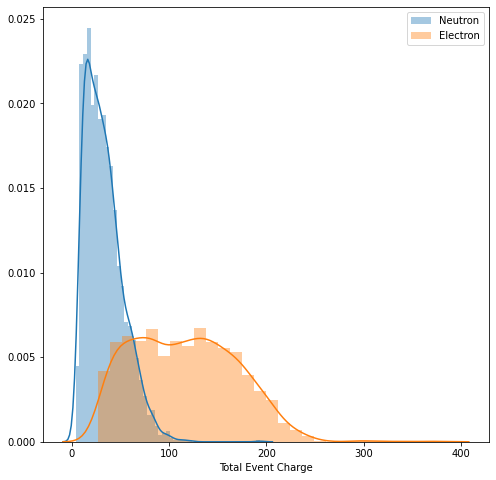

In [45]:
print("neutron charge stats ... \n" + str(stats.describe(neutron_charge_sums))), print("")
print("electron charge stats ... \n" + str(stats.describe(electron_charge_sums)))

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111) 

ax = sns.distplot(neutron_charge_sums, rug = False, axlabel ="Total Event Charge", label = "Neutron")
ax = sns.distplot(electron_charge_sums, rug = False, label = "Electron")
plt.legend()
plt.savefig("charge_separation.png") 

Fit distributions to smoothed KDE probability estimator

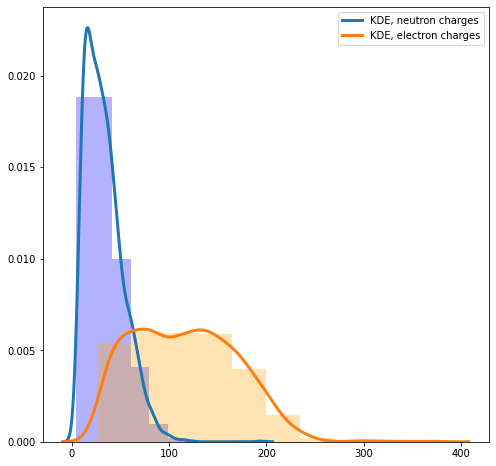

In [46]:
#### --------------------- by total charge ---------------------- #####

kdeNeutronCharge = sm.nonparametric.KDEUnivariate(neutron_charge_sums)
kdeNeutronCharge.fit() # Estimate the densities

kdeElectronCharge = sm.nonparametric.KDEUnivariate(electron_charge_sums)
kdeElectronCharge.fit() # Estimate the densities

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111)

ax.plot(kdeNeutronCharge.support, kdeNeutronCharge.density, lw=3, label='KDE, neutron charges', zorder=10)
ax.plot(kdeElectronCharge.support, kdeElectronCharge.density, lw=3, label='KDE, electron charges', zorder=10)
plt.hist(neutron_charge_sums, bins = 10, density = True, color = "blue", alpha = 0.3)
plt.hist(electron_charge_sums, bins = 10, density = True, color  = "orange", alpha = 0.3 )
plt.legend()


In [58]:
print(float(kdeElectronCharge.evaluate(140)))
print(float(kdeNeutronCharge.evaluate(140)))

0.006034521760418386
1.3094033894676215e-08


In [48]:
def likelihood_classifier_charges(event_data):
    pred_labels = []

    #total charges..
    h5_charges = event_mem_data[:, :, 0]
    h5_charges = np.array(h5_charges)
    h5_charge_sums = h5_charges.sum(axis = 1)

    for i in range(0, event_data.shape[0]):
        if kdeElectronCharge.evaluate(h5_charge_sums[i]) > kdeNeutronCharge.evaluate(h5_charge_sums[i]):
            pred_labels.append(1) #electron
        else:
            pred_labels.append(0) #neutron
       
    pred_labels = np.array(pred_labels)
    return pred_labels

In [49]:
predictions = likelihood_classifier_charges(event_mem_data)

In [50]:
print(predictions[700:900])
print(labels[700:900])

correct = 0
for x in range(0, event_mem_data.shape[0]):
    if predictions[x] == labels[x]:
        correct += 1

accuracy = correct / event_mem_data.shape[0]
print("Accuracy: " + str(accuracy))

[1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1
 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Accuracy: 0.8597461097461098


Likelihood ratio log plot

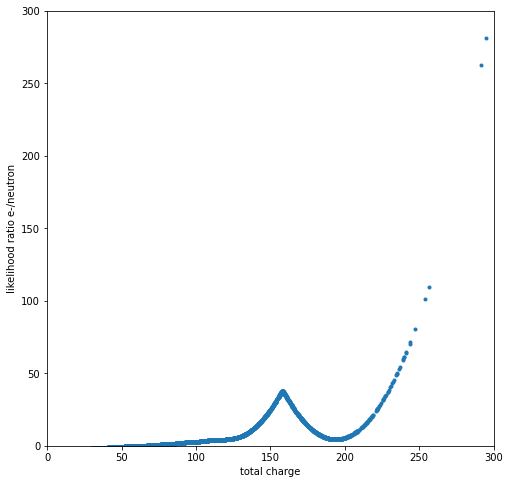

In [51]:
t = []

h5_charges = np.array(h5_charges)
h5_charge_sums = h5_charges.sum(axis = 1)
h5_charge_sums = np.sort(h5_charge_sums) #sort charge sums in ascending order
    
for i in range(0, event_mem_data.shape[0]):
    if kdeNeutronCharge.evaluate(h5_charge_sums[i]) != 0:
        t.append(np.log(float(kdeElectronCharge.evaluate(h5_charge_sums[i])) / float(kdeNeutronCharge.evaluate(h5_charge_sums[i]))))  #electron
    
fig = plt.figure(figsize = (8,8))
axes = fig.gca()
axes.set_xlim([0, 300])
axes.set_ylim([0, 300])
plt.xlabel('total charge')
plt.ylabel('likelihood ratio e-/neutron')
plt.plot(h5_charge_sums[:4882], t, '.')
plt.savefig("charge_likelihood.png") 
#note: unsure about the dip around 150-> 200 total charge

# neutron, electron and both

In [78]:
def likelihoodClassifier(h5_filepath, nhits_input = False, charge_input = False):
    
    with h5py.File(h5_filepath, 'r') as file:
        #print(list(file.keys()))
        h5_event_data = file['event_data']
        h5_nhits = file['nhits']
        h5_labels = file['labels']
        labels = np.array(h5_labels)
        event_mem_data = np.memmap(h5_filepath, mode='r', shape=h5_event_data.shape,
                               offset=h5_event_data.id.get_offset(),
                               dtype=h5_event_data.dtype)
        h5_charges = event_mem_data[:, :, 0]
        
        #print("Event memory data shape: " + str(event_mem_data.shape))
        #print("1634 events. Up to 300 hits per event. 8 features per hit per event")
        nhits = np.array(h5_nhits)
    
    neutron_hits = []
    electron_hits = []
    neutron_charges = []
    electron_charges = []
    
    for i in range(0, event_mem_data.shape[0]):
        if labels[i] == 0:
            neutron_hits.append(nhits[i])
            neutron_charges.append(h5_charges[i, :])
        elif labels[i] == 1:
            electron_hits.append(nhits[i])
            electron_charges.append(h5_charges[i, :]) 
    
    kdeNeutron = sm.nonparametric.KDEUnivariate(neutron_hits)
    kdeNeutron.fit() # Estimate the densities

    kdeElectron = sm.nonparametric.KDEUnivariate(electron_hits)
    kdeElectron.fit() # Estimate the densities
    
    neutron_charges = np.array(neutron_charges)
    electron_charges = np.array(electron_charges)
    
    neutron_charge_sums = neutron_charges.sum(axis = 1)
    electron_charge_sums = electron_charges.sum(axis = 1)
    
    kdeNeutronCharge = sm.nonparametric.KDEUnivariate(neutron_charge_sums)
    kdeNeutronCharge.fit() # Estimate the densities

    kdeElectronCharge = sm.nonparametric.KDEUnivariate(electron_charge_sums)
    kdeElectronCharge.fit() # Estimate the densities
    
    #convert charges to list of charge sums
    h5_charges = pd.DataFrame(h5_charges)
    h5_charge_sums = h5_charges.sum(axis = 1)
    
    pred_labels = []
    
    for i in range(0, event_mem_data.shape[0]):
        if nhits_input and not charge_input:
            if kdeElectron.evaluate(nhits[i]) > kdeNeutron.evaluate(nhits[i]) :
                pred_labels.append(1)  #electron
            else:
                pred_labels.append(0)  #neutron
        elif not nhits_input and charge_input:
            if kdeElectronCharge.evaluate(h5_charge_sums[i]) > kdeNeutronCharge.evaluate(h5_charge_sums[i]):
                pred_labels.append(1)
            else:
                pred_labels.append(0)  #neutron
        elif nhits_input and charge_input:
            if (kdeElectronCharge.evaluate(h5_charge_sums[i]) * kdeElectron.evaluate(nhits[i])) > (kdeNeutronCharge.evaluate(h5_charge_sums[i]) * kdeNeutron.evaluate(nhits[i])):
                pred_labels.append(1) #electron
            else:
                pred_labels.append(0)  #neutron
    
    pred_labels = np.array(pred_labels)
    
    correct = 0
    for x in range(0, event_mem_data.shape[0]):
        if pred_labels[x] == labels[x]:
            correct += 1

    accuracy = correct / event_mem_data.shape[0]
    
    return accuracy

In [80]:
data_path = h5_filepath
print(likelihoodClassifier(data_path, nhits_input = True, charge_input = False))
print(likelihoodClassifier(data_path, nhits_input = False, charge_input = True))
print(likelihoodClassifier(data_path, nhits_input = True, charge_input = True))

0.8501228501228502
0.8597461097461098
0.8597461097461098
